In [57]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        data.extend(content)

In [58]:
# This is a single invocation
# data[0]

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls
0,5449e7edd2611d18,"A.B.C.E.G,D,F",A,A,5841,102,True,142281,148099,5804,"[{'called': 'G', 'caller': 'A', 'local': True,..."
1,d8657d00f679f0cb,"A.B.C.E.G,D,F",A,A,5236,103,True,144552,149773,5198,"[{'called': 'G', 'caller': 'A', 'local': True,..."
2,f95764eae0f1dce3,"A.B.C.E.G,D,F",A,A,7070,101,True,138963,146030,7066,"[{'called': 'G', 'caller': 'A', 'local': True,..."
3,e417544bcfe342ac,"A.B.C.E.G,D,F",A,A,3487,121,True,146316,149803,3485,"[{'called': 'G', 'caller': 'A', 'local': True,..."
4,009e30e5634f638f,"A.B.C.E.G,D,F",A,D,2942,82,False,141122,144061,2930,"[{'called': 'E', 'caller': 'D', 'local': False..."
...,...,...,...,...,...,...,...,...,...,...,...
5872,4a11503ae64f1c45,"A.B.D,C,E,F,G",A,G,1249,89,False,588477,589725,1239,"[{'called': 'G', 'caller': 'G', 'local': True,..."
5873,029d4d8d663df8e0,"A.B.D,C,E,F,G",A,G,525,98,False,590065,590562,481,"[{'called': 'G', 'caller': 'G', 'local': True,..."
5874,66e67701778e592b,"A.B.D,C,E,F,G",A,G,367,107,False,591281,591643,365,"[{'called': 'G', 'caller': 'G', 'local': True,..."
5875,404a58fd3e1817cd,"A.B.D,C,E,F,G",A,G,521,108,False,592722,593102,360,"[{'called': 'G', 'caller': 'G', 'local': True,..."


In [60]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 202


<AxesSubplot:ylabel='billedDuration'>

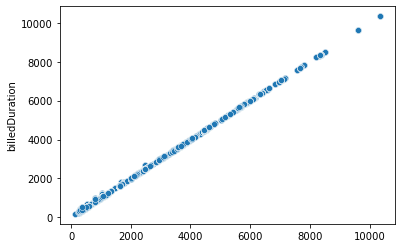

In [61]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

<AxesSubplot:xlabel='startTimestamp', ylabel='billedDuration'>

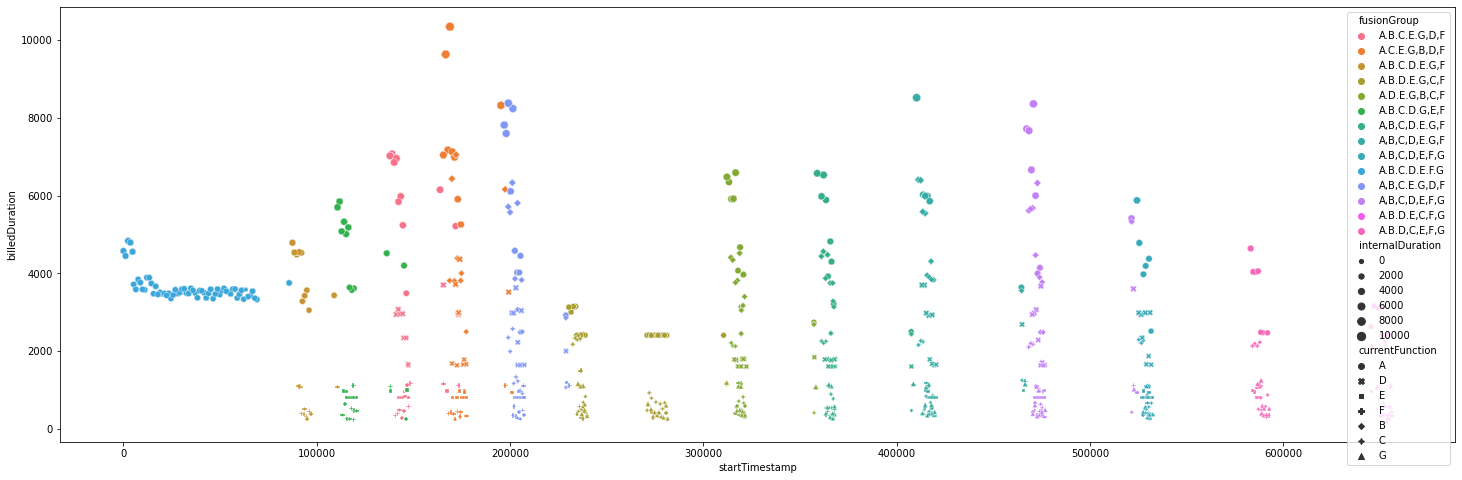

In [62]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

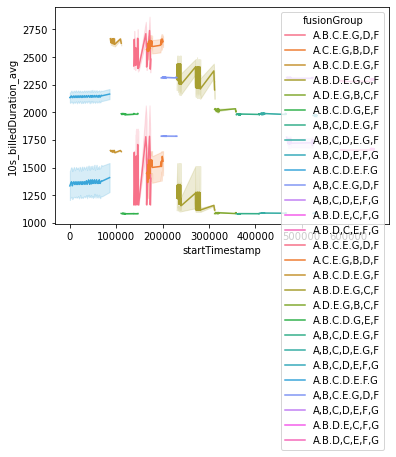

In [63]:
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [64]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')
grouped

Total Number of Invocations should be: 5877 == 5877


,billedDuration,startTimestamp,endTimestamp,fusionGroup,numInvocations
,sum,min,max,min,
traceId,,,,,
009e30e5634f638f,137500,137858,144861,"A.B.C.E.G,D,F",51
00c43c09dcb1986a,45933,317921,321983,"A.D.E.G,B,C,F",41
017e3e63835aa884,25957,310456,313240,"A.B.D.E.G,C,F",19
029d4d8d663df8e0,10665,587213,590562,"A.B.D,C,E,F,G",9
03444a2877e73eee,55103,357170,359909,"A.D.E.G,B,C,F",37
...,...,...,...,...,...
f7f3fdb7590990a2,2178,649642,650601,"A.B.D.E,C,F,G",5
f95764eae0f1dce3,98008,138963,146030,"A.B.C.E.G,D,F",45


<Figure size 1800x576 with 0 Axes>

<AxesSubplot:xlabel="('startTimestamp', 'min')", ylabel="('billedDuration', 'sum')">

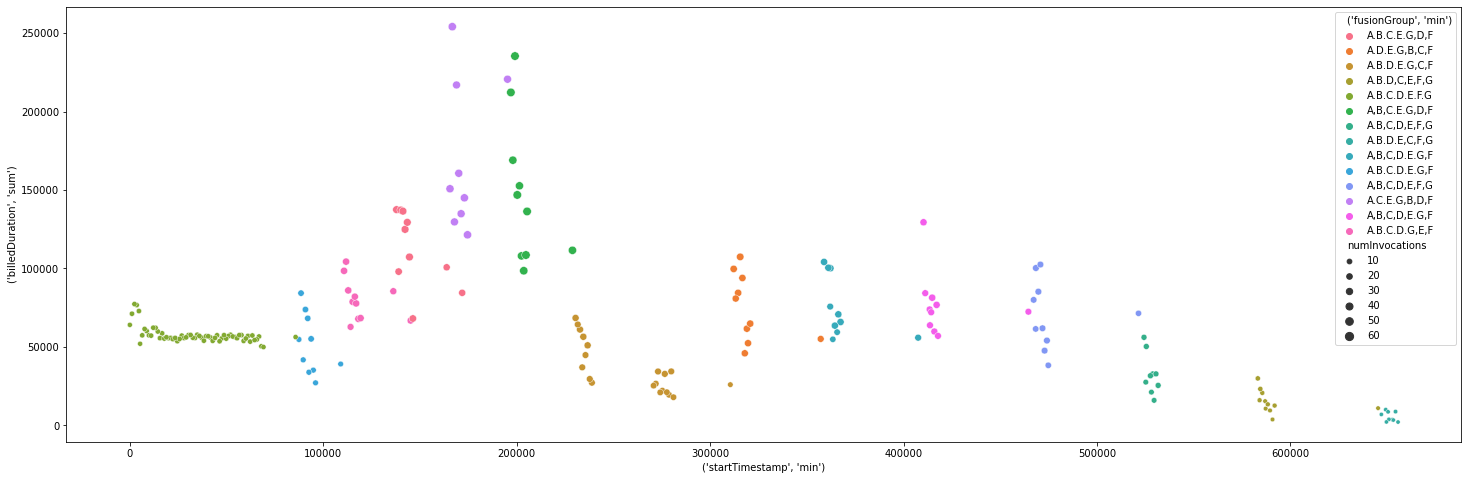

In [67]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size="numInvocations")

<AxesSubplot:xlabel="('startTimestamp', 'min')", ylabel='numInvocations'>

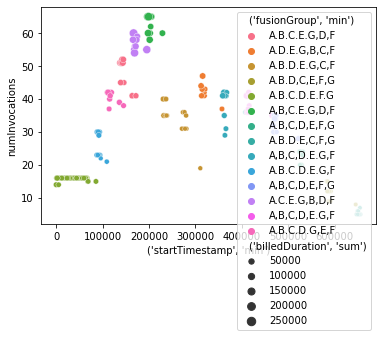

In [66]:
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y="numInvocations", hue=grouped['fusionGroup', 'min'], size=grouped['billedDuration', 'sum'])